# Bone Fracture Image Classification Analysis

# Imports

In [72]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Functions

In [52]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_and_preprocess_image(image_path, target_size=(250, 250)):
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            img = img.convert('RGB')

            img_array = np.array(img) / 255.0
            img_array = img_array.astype(np.float32)
        return img_array
    except IOError as e:

        print(f"Error loading image {image_path}: {e}")
        return None

def grab_images(directory):
    X = []
    y = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                img = load_and_preprocess_image(file_path)
                if img is not None:
                    X.append(img)
                    label = root.split(os.sep)[-1]
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

def create_model():
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(), 
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.summary()

# Main Path

In [1]:
PATH = "/Users/maukanmir/Downloads/archive/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/"
fractured, non_fractured = "fractured", "not fractured"

In [8]:
train_path, test_path, val_path = PATH + "train/", PATH + "test/", PATH + "val/"

# Read in training, test and validation data

In [48]:
X_train, y_train = grab_images(train_path)
X_test, y_test = grab_images(test_path)
X_val, y_val = grab_images(val_path)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Check Class Balance

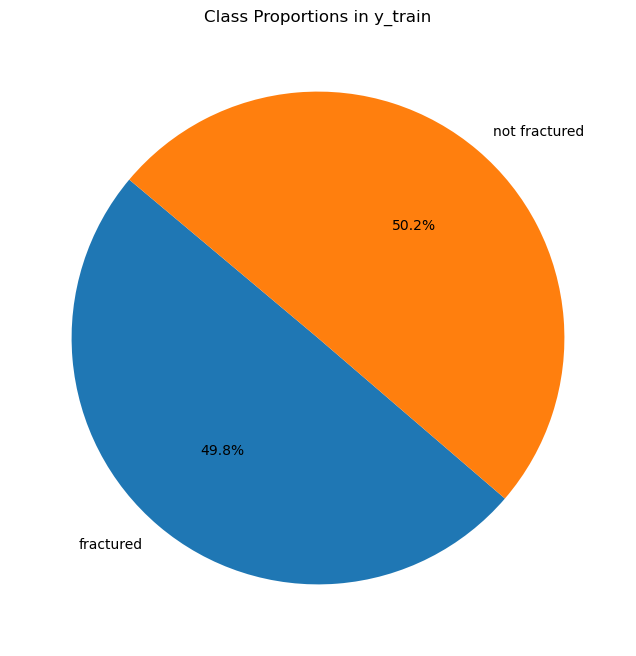

In [77]:
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=140)
plt.title('Class Proportions in y_train')
plt.show()

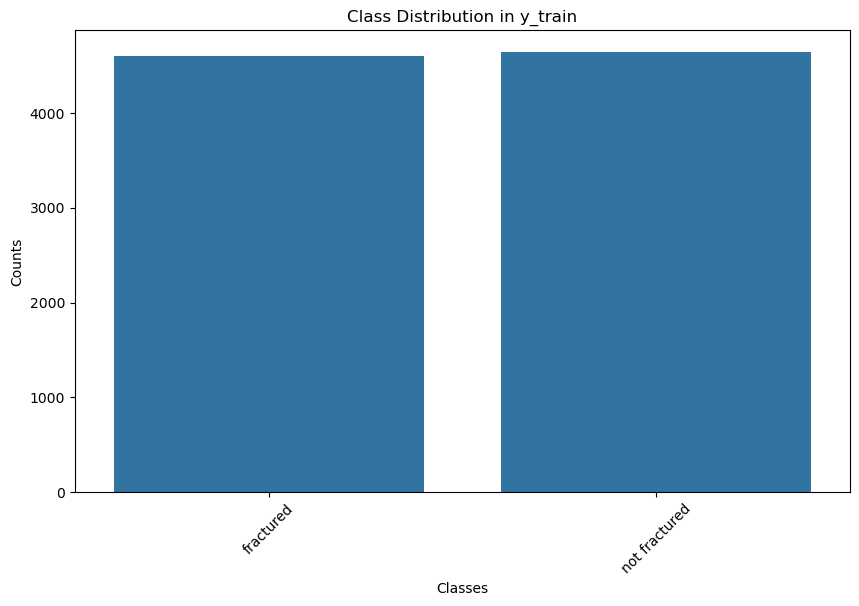

In [75]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution in y_train')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

# Data Augmentation

In [50]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'
)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


# Create Model

In [53]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 128)      0

In [63]:
history = model.fit(
    train_generator,
    steps_per_epoch=100, 
    epochs=20,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=0
)

In [65]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 2s 133ms/step - loss: 0.2981 - accuracy: 0.8636
Test Accuracy: 0.8636363744735718


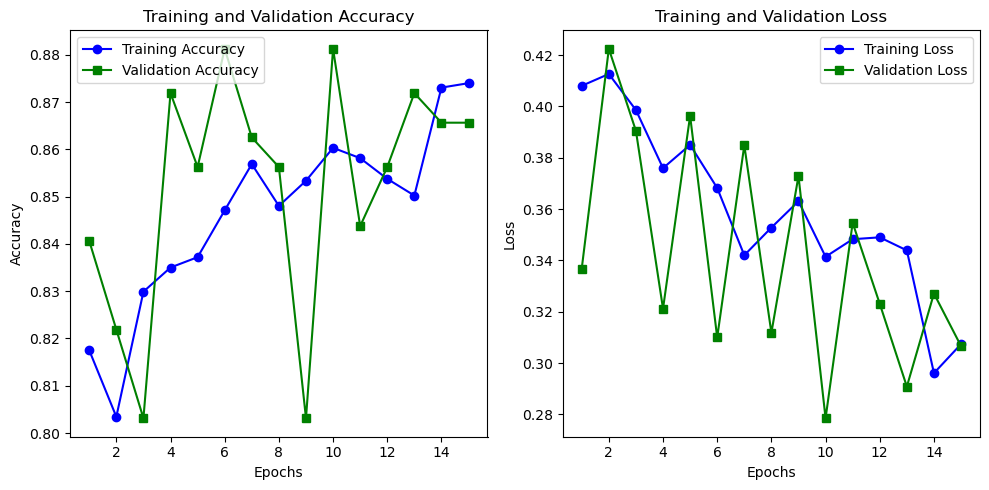

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'gs-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'gs-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Predictions

In [69]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

encoder = LabelEncoder()
y_test_encoded = encoder.fit_transform(y_test) 

16/16 [==============================] - 1s 83ms/step


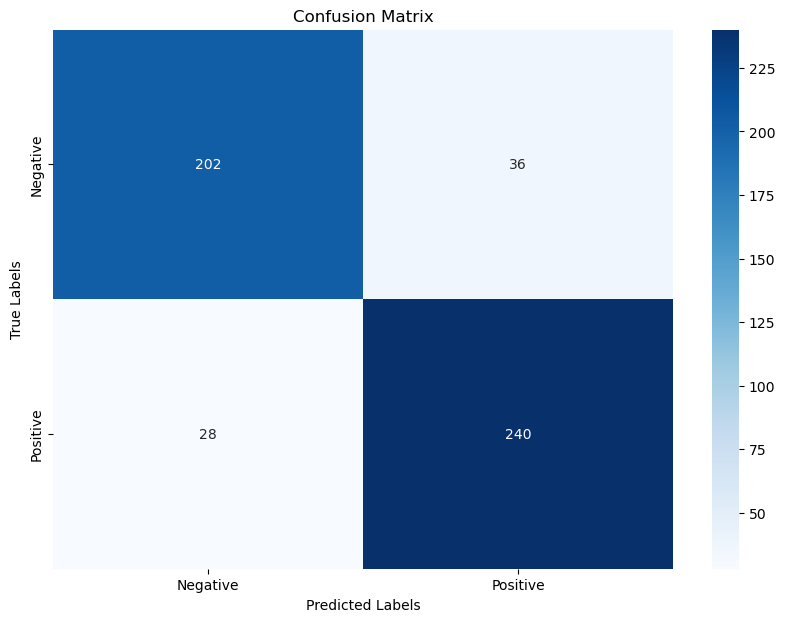

In [70]:
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [73]:
report = classification_report(y_test_encoded, y_pred, target_names=['Negative', 'Positive'])

print(report)

              precision    recall  f1-score   support

    Negative       0.88      0.85      0.86       238
    Positive       0.87      0.90      0.88       268

    accuracy                           0.87       506
   macro avg       0.87      0.87      0.87       506
weighted avg       0.87      0.87      0.87       506

